<div style="padding: 15px; border: 1px solid #d4edda; background-color: #d4edda; color: #155724; border-radius: 5px; font-size: 30px;">

  <strong> 1. Setup </strong>
</div>



In [1]:
from utils import *

In [2]:
#make the model start with same weights
tf.random.set_seed(221)

In [3]:
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [ ]:
# ------- Parameters ------- 

# KNN
n_neighbors = 10
metric = 'cosine'
weights = 'distance'

# Glove
emb_size = 100 # start small than increase to find the best value

# TF-IDF
max_df = 0.8 # we are removing terms that appear in >80% of tweets

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

In [46]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

<div style="padding: 15px; border: 1px solid #d4edda; background-color: #d4edda; color: #155724; border-radius: 5px; font-size: 30px;">

  <strong> 2. KNN </strong>
</div>

## **2.1** Bag of Words

### **2.1.1** Unigrams

In [8]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn)

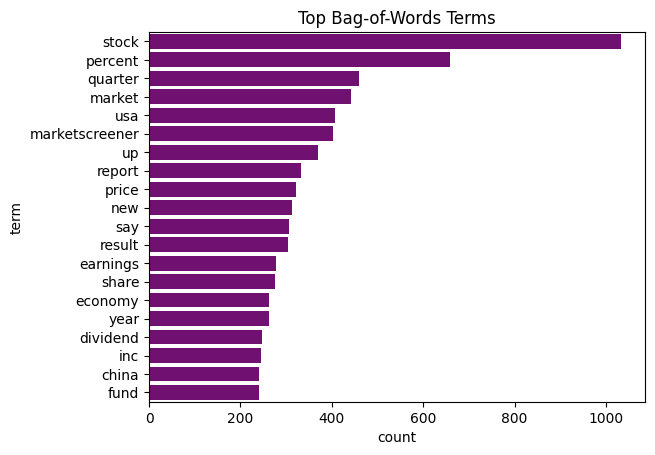

In [9]:
clean_bow_sum = np.array(X_bow_unigrams.sum(axis=0)).flatten()
clean_terms = bow_unigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='purple')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [27]:
print(classification_report(y_pred_bow_unigrams, y_val))

              precision    recall  f1-score   support

           0       0.41      0.74      0.52       159
           1       0.64      0.66      0.65       374
           2       0.92      0.83      0.87      1376

    accuracy                           0.79      1909
   macro avg       0.66      0.74      0.68      1909
weighted avg       0.82      0.79      0.80      1909



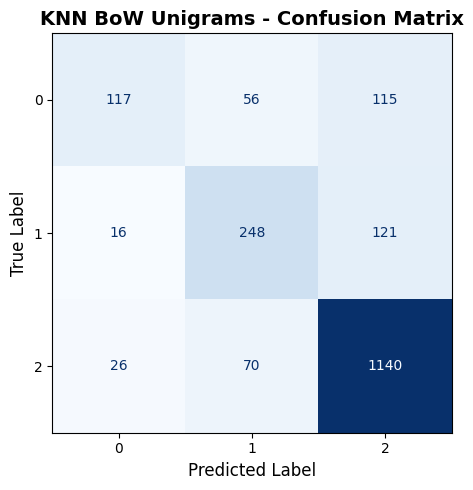

In [11]:
plot_confusion_matrix(y_val, y_pred_bow_unigrams, title="KNN BoW Unigrams - Confusion Matrix", labels=[0, 1, 2], cmap="Blues")

### **2.1.2** Unigrams + Bigrams

In [12]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_bow_bigrams, y_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn, ngram_range=(1,2))

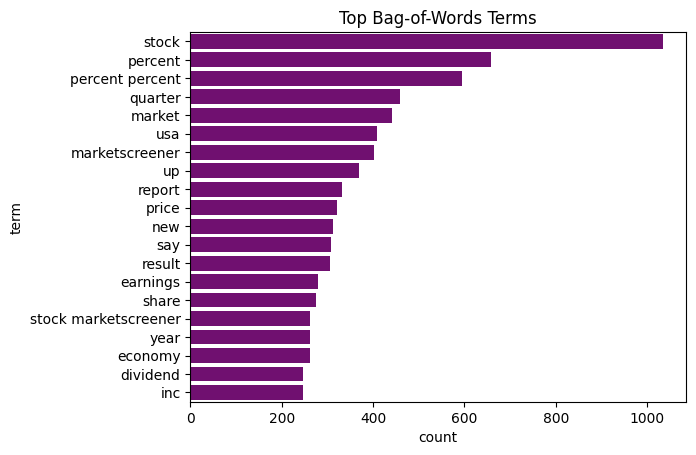

In [13]:
clean_bow_sum = np.array(X_bow_bigrams.sum(axis=0)).flatten()
clean_terms = bow_bigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='purple')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [26]:
print(classification_report(y_pred_bow_bigrams, y_val))

              precision    recall  f1-score   support

           0       0.38      0.69      0.49       158
           1       0.64      0.67      0.65       369
           2       0.92      0.83      0.87      1382

    accuracy                           0.78      1909
   macro avg       0.65      0.73      0.67      1909
weighted avg       0.82      0.78      0.80      1909



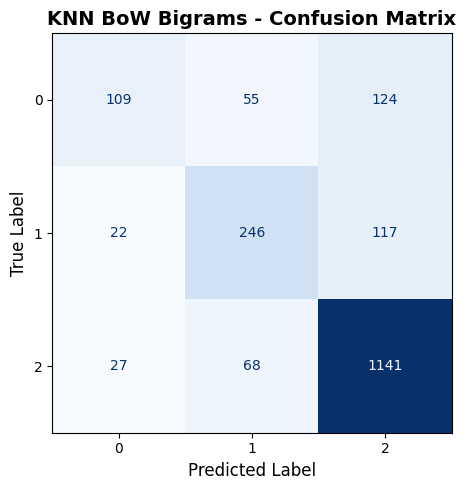

In [15]:
plot_confusion_matrix(y_val, y_pred_bow_bigrams, title="KNN BoW Bigrams - Confusion Matrix", labels=[0, 1, 2], cmap="Blues")

## **2.2** TF-IDF

### **2.2.1** Unigrams

In [30]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_unigrams, y_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=modelknn)

In [31]:
tfidf_unigrams.get_feature_names_out()

array(['aa', 'aal', 'aaoi', ..., 'zyen', 'zynex', 'zynga'], dtype=object)

In [22]:
tfidf_unigrams.vocabulary_

{'nasdaq': 6781,
 'price': 7940,
 'percent': 7551,
 'senior': 9099,
 'note': 7013,
 'future': 4199,
 'up': 12012,
 'november': 7030,
 'nonfarm': 6970,
 'private': 7965,
 'payroll': 7503,
 'consensus': 2243,
 'ticker_econx': 10815,
 'twitter': 11857,
 'user': 12059,
 'explain': 3718,
 'kohl': 5680,
 'stock': 9730,
 'got': 4433,
 'obliterated': 7101,
 'reporting': 8502,
 'earnings': 3232,
 'agilysys': 260,
 'restaurant': 8564,
 'find': 3932,
 'sustainable': 9946,
 'method': 6448,
 'limiting': 5945,
 'food': 4045,
 'waste': 12304,
 'holiday': 4818,
 'make': 6173,
 'retirement': 8592,
 'top': 11647,
 'ranked': 8236,
 'mutual': 6738,
 'fund': 4186,
 'february': 3858,
 'could': 2391,
 'applied': 590,
 'dna': 3045,
 'science': 8990,
 'inc': 5094,
 'apdn': 569,
 'see': 9059,
 'reversal': 8616,
 'breaking': 1377,
 'week': 12353,
 'low': 6074,
 'lamp': 5746,
 'news': 6884,
 'usmca': 12062,
 'affect': 225,
 'usa': 12051,
 'steelmaker': 9693,
 'auto': 818,
 'manufacturer': 6220,
 'manchester': 620

In [23]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_unigrams.get_feature_names_out(), tfidf_unigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'four': 6.996059238486293, 'fourth': 5.9515141710884585, 'fowl': 9.247351037092788, 'fox': 8.554203856532842, 'foxbusiness': 8.554203856532842, 'foxconn': 8.554203856532842, 'foxnews': 9.247351037092788, 'fpga': 9.247351037092788, 'fpp': 9.247351037092788, 'fpt': 9.247351037092788}


In [25]:
print(classification_report(y_pred_tfidf_unigrams, y_val))

              precision    recall  f1-score   support

           0       0.44      0.72      0.55       176
           1       0.65      0.69      0.67       364
           2       0.93      0.84      0.88      1369

    accuracy                           0.80      1909
   macro avg       0.67      0.75      0.70      1909
weighted avg       0.83      0.80      0.81      1909



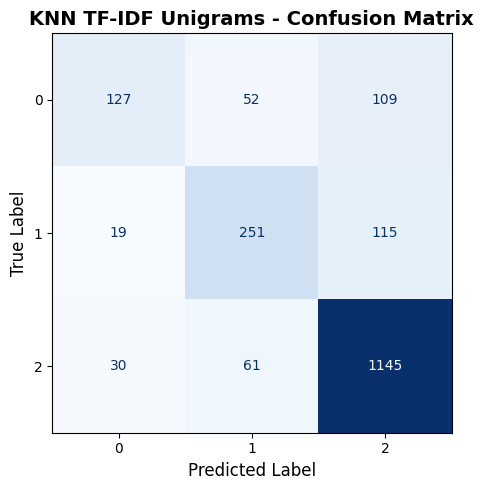

In [164]:
plot_confusion_matrix(y_val, y_pred_tfidf_unigrams, title="KNN TF-IDF Unigrams - Confusion Matrix", labels=[0, 1, 2], cmap="Blues")

### **2.2.2** Bigrams

In [32]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_bigrams, y_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=modelknn, ngram_range=(1,2))

In [33]:
tfidf_bigrams.get_feature_names_out()

array(['aa', 'aa cc', 'aal', ..., 'zynga', 'zynga nasdaq', 'zynga share'],
      dtype=object)

In [34]:
tfidf_bigrams.vocabulary_

{'nasdaq': 31116,
 'price': 36807,
 'percent': 34740,
 'senior': 42616,
 'note': 32303,
 'nasdaq price': 31201,
 'price percent': 36870,
 'percent percent': 34908,
 'percent senior': 34950,
 'senior note': 42629,
 'future': 19130,
 'up': 52401,
 'future up': 19176,
 'november': 32386,
 'nonfarm': 32196,
 'private': 37013,
 'payroll': 34549,
 'consensus': 10005,
 'ticker_econx': 49004,
 'november nonfarm': 32399,
 'nonfarm private': 32198,
 'private payroll': 37023,
 'payroll consensus': 34550,
 'consensus ticker_econx': 10021,
 'twitter': 51771,
 'user': 53151,
 'explain': 16662,
 'kohl': 25824,
 'stock': 45403,
 'got': 20386,
 'obliterated': 32723,
 'reporting': 39606,
 'earnings': 14509,
 'twitter user': 51788,
 'user explain': 53154,
 'explain kohl': 16663,
 'kohl stock': 25835,
 'stock got': 45477,
 'got obliterated': 20389,
 'obliterated reporting': 32724,
 'reporting earnings': 39608,
 'agilysys': 927,
 'restaurant': 39887,
 'find': 17839,
 'sustainable': 46648,
 'method': 29606,

In [35]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_bigrams.get_feature_names_out(), tfidf_bigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'baxterinternational stock': 9.247351037092788, 'bayer': 8.331060305218632, 'bayer asks': 9.247351037092788, 'bayer face': 9.247351037092788, 'bayer plaintiff': 9.247351037092788, 'bayer seek': 9.247351037092788, 'bayer stock': 9.247351037092788, 'bayway': 9.247351037092788, 'bayway refinery': 9.247351037092788, 'bazooka': 8.841885928984624}


In [36]:
print(classification_report(y_pred_tfidf_bigrams, y_val))
print("Accuracy:", accuracy_score(y_val, y_pred_tfidf_bigrams))

              precision    recall  f1-score   support

           0       0.43      0.71      0.53       173
           1       0.64      0.68      0.66       362
           2       0.92      0.83      0.87      1374

    accuracy                           0.79      1909
   macro avg       0.66      0.74      0.69      1909
weighted avg       0.82      0.79      0.80      1909

Accuracy: 0.7888947092718701


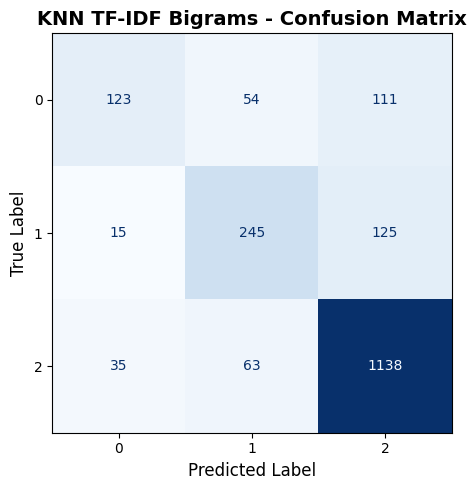

In [37]:
plot_confusion_matrix(y_val, y_pred_tfidf_bigrams, title="KNN TF-IDF Bigrams - Confusion Matrix", labels=[0, 1, 2], cmap="Blues")

## **2.3** Word2Vec

In [40]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=modelknn)

In [41]:
print(classification_report(y_pred_vec, y_val))

              precision    recall  f1-score   support

           0       0.01      0.67      0.01         3
           1       0.06      0.59      0.11        39
           2       0.99      0.66      0.79      1867

    accuracy                           0.65      1909
   macro avg       0.35      0.64      0.30      1909
weighted avg       0.97      0.65      0.77      1909



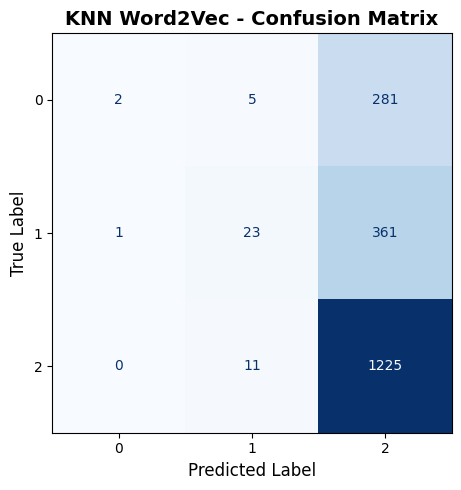

In [42]:
plot_confusion_matrix(y_val, y_pred_vec, title="KNN Word2Vec - Confusion Matrix", labels=[0, 1, 2], cmap="Blues")

## **2.4** Glove

In [56]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_glove_avg, y_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=modelknn)

100%|██████████| 1909/1909 [00:00<00:00, 26323.42it/s]


In [57]:
print(classification_report(y_pred_glove, y_val))

              precision    recall  f1-score   support

           0       0.29      0.55      0.38       151
           1       0.56      0.59      0.58       366
           2       0.92      0.82      0.87      1392

    accuracy                           0.75      1909
   macro avg       0.59      0.65      0.61      1909
weighted avg       0.80      0.75      0.77      1909



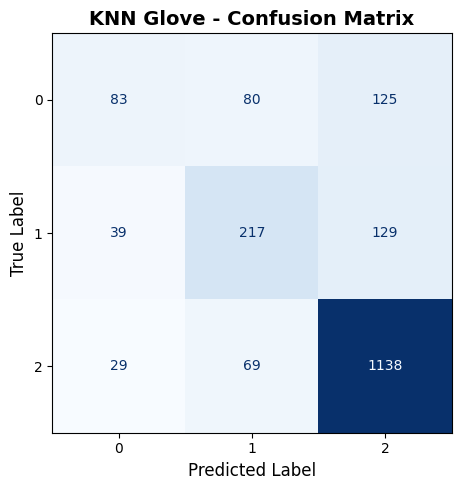

In [58]:
plot_confusion_matrix(y_val, y_pred_glove, title="KNN Glove - Confusion Matrix", labels=[0, 1, 2], cmap="Blues")